In [1]:
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils

In [7]:
import numpy as np

image_data = np.load('../input/ocular-data/image_data.npy')
labels = np.load('../input/ocular-data/labels.npy')

In [8]:
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

In [10]:
y_train = np_utils.to_categorical(y_train, num_classes = 7)
y_test = np_utils.to_categorical(y_test, num_classes = 7)

In [11]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (11284, 100, 100, 3)
SHAPE OF TESTING IMAGE DATA : (2821, 100, 100, 3)
SHAPE OF TRAINING LABELS : (11284, 7)
SHAPE OF TESTING LABELS : (2821, 7)


In [12]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [30]:
num_classes = 7
input_shape = (100, 100, 3)

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 100
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 2500


In [31]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [32]:
datagen = ImageDataGenerator() # define your data augmentation
bgen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [34]:
y_gen = [bgen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True))

(array([0., 1.], dtype=float32), array([96576, 16096]))


In [33]:
datagen = ImageDataGenerator()
balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-05-07 08:50:08.200863: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1354080000 exceeds 10% of free system memory.


In [43]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


In [44]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [45]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [46]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x


In [47]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [49]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    balanced_gen,
    batch_size=batch_size,
    epochs=num_epochs,
    #validation_split=validation_split,
    validation_data=(x_test,y_test)
)

Epoch 1/100
503/503 [==============================] - 250s 469ms/step - loss: 1.6467 - accuracy: 0.3730 - top-5-accuracy: 0.9521 - val_loss: 1.5343 - val_accuracy: 0.4392 - val_top-5-accuracy: 0.9734
Epoch 2/100
503/503 [==============================] - 233s 463ms/step - loss: 1.4529 - accuracy: 0.4769 - top-5-accuracy: 0.9761 - val_loss: 1.4341 - val_accuracy: 0.4708 - val_top-5-accuracy: 0.9826
Epoch 3/100
503/503 [==============================] - 233s 463ms/step - loss: 1.3425 - accuracy: 0.5374 - top-5-accuracy: 0.9850 - val_loss: 1.3621 - val_accuracy: 0.5066 - val_top-5-accuracy: 0.9887
Epoch 4/100
503/503 [==============================] - 233s 463ms/step - loss: 1.2674 - accuracy: 0.5759 - top-5-accuracy: 0.9891 - val_loss: 1.3441 - val_accuracy: 0.5307 - val_top-5-accuracy: 0.9918
Epoch 5/100
503/503 [==============================] - 233s 463ms/step - loss: 1.2080 - accuracy: 0.6079 - top-5-accuracy: 0.9905 - val_loss: 1.2837 - val_accuracy: 0.5650 - val_top-5-accuracy: 0.

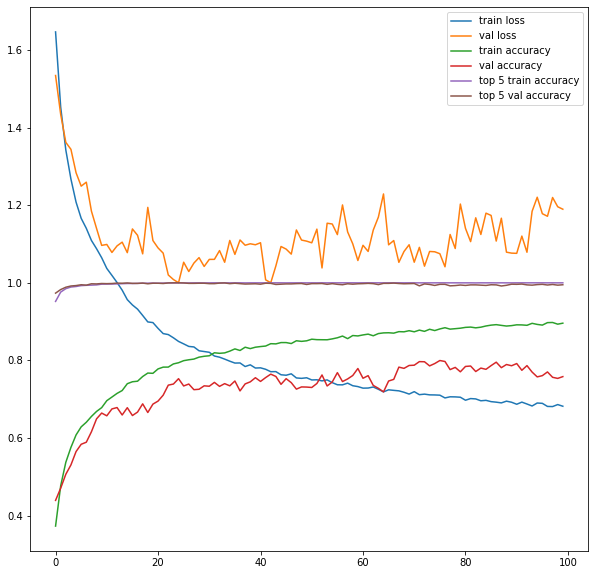

In [52]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['top-5-accuracy'], label='top 5 train accuracy')
plt.plot(history.history['val_top-5-accuracy'], label='top 5 val accuracy')
plt.legend()
plt.show()

In [53]:
y_pred = model.predict(x_test)

In [54]:
y_pred_class = y_pred.argmax(axis=1)
y_test_1 = y_test.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

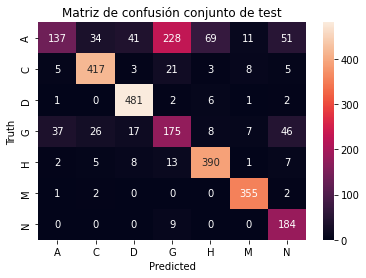

In [55]:
from sklearn.metrics import confusion_matrix

labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N']

cf_matrix = confusion_matrix(y_test_1, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [57]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.960641414909154
AP Score: 0.8306066506338892

              precision    recall  f1-score   support

           0       0.76      0.20      0.32       571
           1       0.88      0.88      0.88       462
           2       0.90      0.98      0.94       493
           3       0.40      0.49      0.44       316
           4       0.84      0.90      0.87       426
           5       0.94      0.98      0.96       360
           6       0.67      0.95      0.78       193

   micro avg       0.79      0.74      0.76      2821
   macro avg       0.77      0.77      0.74      2821
weighted avg       0.79      0.74      0.73      2821
 samples avg       0.74      0.74      0.74      2821



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_1,y_pred_class)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[137  34  41 228  69  11  51]
 [  5 417   3  21   3   8   5]
 [  1   0 481   2   6   1   2]
 [ 37  26  17 175   8   7  46]
 [  2   5   8  13 390   1   7]
 [  1   2   0   0   0 355   2]
 [  0   0   0   9   0   0 184]]
acc: 0.1964
sensitivity: 0.8012
specificity: 0.9882


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.75      0.24      0.36       571
           C       0.86      0.90      0.88       462
           D       0.87      0.98      0.92       493
           G       0.39      0.55      0.46       316
           H       0.82      0.92      0.86       426
           M       0.93      0.99      0.96       360
           N       0.62      0.95      0.75       193

    accuracy                           0.76      2821
   macro avg       0.75      0.79      0.74      2821
weighted avg       0.77      0.76      0.73      2821

